In [1]:
import random
import warnings
warnings.filterwarnings('ignore')
import numpy.linalg as linalg
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import datetime
from datetime import timedelta, datetime, timezone
import tqdm
import geopandas as gpd
from shapely.geometry import Point
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LightSource
from sklearn.preprocessing import QuantileTransformer
import skgstat as skg
from skgstat import models
import sklearn as sklearn
from sklearn.neighbors import KDTree
import math
from scipy.spatial import distance_matrix
from scipy.interpolate import Rbf
from tqdm import tqdm
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.tri as tri
#import argparse
import shapely
import glob
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import argparse
import seaborn as sns
from sklearn.linear_model import LinearRegression
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import math
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from matplotlib.gridspec import GridSpec
import pickle
import matplotlib.ticker as mtick
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as mtick
from scipy.spatial import cKDTree
import matplotlib.patches as mpatches  # Needed for manually creating legend patches


In [ ]:
root_path = '/scratch/users/pburdeau/data/gas_composition'
ghgrp_path = os.sep.join([root_path, 'ghgrp', 'ghgrp_v2.csv'])
ghgrp = pd.read_csv(ghgrp_path)
shapefiles_path = root_path + '/shapefiles'
out_path = root_path + '/out'

In [ ]:
def propagate_uncertainties_normalization(data_on_grid):
    components = ['HE', 'CO2', 'H2', 'N2', 'H2S', 'AR', 'O2', 'C1', 'C2', 'C3', 'N-C4', 'I-C4', 'N-C5', 'I-C5', 'C6+']
    new_components = [comp + '_y' for comp in components]
    components = new_components
    
    # Calculate the covariance and correlation matrices
    correlation_matrix = data_on_grid[components].corr()
    covariance_matrix = data_on_grid[components].cov()
    
    # Generate list of standard deviation columns for each component
    list_stds = ['std_' + comp[:-2]  for comp in components]
    
    # Extract values and their uncertainties
    values = data_on_grid[components].values
    uncertainties = data_on_grid[list_stds].values
    
    # Step 1: Calculate the Sum and its Uncertainty
    sum_values = np.nansum(values, axis=1)
    uncertainty_sum = np.sqrt(np.nansum(uncertainties**2, axis=1))
    
    # Step 2: Normalize the Values to sum to 100 and add to DataFrame
    for i, comp in enumerate(components):
        data_on_grid[comp] = values[:, i] * 100 / sum_values
    
    # Step 3: Calculate the Fractional Uncertainty of Each Normalized Value
    for i, comp in enumerate(components):
        fractional_uncertainty = np.sqrt((uncertainties[:, i] / values[:, i])**2 + (uncertainty_sum / sum_values)**2)
        data_on_grid['std_' + comp[:-2]] = fractional_uncertainty
    
    # Step 4: Calculate the Final Absolute Uncertainty for normalized values and add to DataFrame
    for i, comp in enumerate(components):
        absolute_uncertainty = data_on_grid['std_' + comp[:-2]] * data_on_grid[comp] / sum_values
        data_on_grid['std_' + comp[:-2]] = absolute_uncertainty
    for i, comp in enumerate(components):
        data_on_grid[comp]
    
    # Step 5: Add a column to check if the sum of the normalized values is 100
    data_on_grid['sum_check'] = data_on_grid[components].sum(axis=1).round(2)
    

    # Step 6: Recompute error metrics
    comp = 'C1_y'
    base_comp = comp[:-2]  # Remove '_y' suffix to match with '_x'
    data_on_grid['abs_error'] = np.abs(data_on_grid[comp] - data_on_grid[base_comp + '_x'])
    data_on_grid['sq_error'] = (data_on_grid[comp] - data_on_grid[base_comp + '_x']) ** 2
    data_on_grid['nse'] = ((data_on_grid[comp] - data_on_grid[base_comp + '_x']) / data_on_grid['std_C1']) ** 2
    
    return data_on_grid

def plot_comparison_lists_v4(data_source, nbins, threshold, comp, merged_simple_kriging_list, merged_kriging_list, merged_nn_list=None, propagate=False, select_basin = False, basin_list=None, change_beta=False, new_beta=None):
    if select_basin:
        merged_simple_kriging_list_new = []
        merged_kriging_list_new = []
        merged_nn_list_new = []
        for merged_simple_kriging, merged_kriging, merged_nn in zip(merged_simple_kriging_list, merged_kriging_list, merged_nn_list):
            merged_simple_kriging_list_new.append(merged_simple_kriging[merged_simple_kriging.BASIN_NAME.isin(basin_list)])
            merged_kriging_list_new.append(merged_kriging[merged_kriging.BASIN_NAME.isin(basin_list)])
            merged_nn_list_new.append(merged_nn[merged_nn.BASIN_NAME.isin(basin_list)])
    
        merged_simple_kriging_list = merged_simple_kriging_list_new
        merged_kriging_list = merged_kriging_list_new
        merged_nn_list = merged_nn_list_new
    
    def predic_beta(pred1, pred_1_std, pred2, beta):
        weight_krig = 1
        weight_pred = beta * (pred_1_std ** 2)
        sum_weights = weight_krig + weight_pred
        prediction = (pred1 + weight_pred * pred2) / sum_weights
        return prediction
     
    if change_beta:
        merged_kriging_list_new = []
        for merged_kriging, merged_simple_kriging in zip(merged_kriging_list,merged_simple_kriging_list):
            df = merged_kriging.copy()
            df_simple = merged_simple_kriging.copy()
            df[f'{comp}_y'] = predic_beta(df_simple[f'{comp}_y'], df[f'std_{comp}'],
                                  df[f'{comp}_predic_gor'], new_beta)
            df['abs_error'] = np.abs(df[comp + '_y'] - df[comp + '_x'])

            merged_kriging_list_new.append(df)
        
        merged_kriging_list = merged_kriging_list_new

    
    print('simple_kriging', len(pd.concat(merged_simple_kriging_list)))
    print('kriging', len(pd.concat(merged_kriging_list)))

    print('nn', len(pd.concat(merged_nn_list)))
    # Remove rows with any NaN values in all DataFrames in the lists
    merged_simple_kriging_list = [df.dropna(subset=['abs_error', 'sq_error', 'closest_distance', 'std_' + comp]).drop_duplicates() for df in merged_simple_kriging_list]
    merged_kriging_list = [df.dropna(subset=['abs_error', 'sq_error', 'closest_distance', 'std_' + comp]).drop_duplicates() for df in merged_kriging_list]
    merged_nn_list = [df.dropna(subset=['abs_error', 'sq_error', 'closest_distance', 'std_' + comp]).drop_duplicates() for df in merged_nn_list]
    
    print('simple_kriging', len(pd.concat(merged_simple_kriging_list)))
    print('kriging', len(pd.concat(merged_kriging_list)))

    print('nn', len(pd.concat(merged_nn_list)))

    # Create a dictionary to hold the lists of dataframes and names
    data_dict = {
        'Our method': merged_kriging_list,
        'Ordinary kriging': merged_simple_kriging_list,
        'Nearest neighbor': merged_nn_list
    }
    data_dict_var = {
        'Our method': merged_kriging_list,
        'Ordinary kriging': merged_simple_kriging_list
    }

    # Filter out None entries from data_dict
    data_dict = {name: dfs for name, dfs in data_dict.items() if dfs is not None}

    def select_equal_size_bins(df_list, column, n_bins=nbins, threshold=threshold):
        concatenated_df = pd.concat(df_list, ignore_index=True)
        if propagate:
            concatenated_df = propagate_uncertainties_normalization(concatenated_df)

        sorted_values = concatenated_df[column].sort_values()#.drop_duplicates() # Remove NaNs, sort values

        # Determine the upper cutoff (remove only the highest values, keeping the lower `threshold` fraction)
        upper_cutoff = np.quantile(sorted_values, threshold)  # Keep only the lower x%

        # Filter values to exclude the highest distances
        filtered_values = sorted_values[sorted_values <= upper_cutoff]

        # Compute bin edges so that each bin contains the same number of points
        bin_edges = [filtered_values.iloc[0]]  # Start with the min value
        for i in range(1, n_bins):
            cutoff_index = int(len(filtered_values) * i / n_bins)  # Find index for equal split
            bin_edges.append(filtered_values.iloc[cutoff_index])
        bin_edges.append(filtered_values.iloc[-1])  # Include max value

        return sorted(set(bin_edges))  # Ensure unique and sorted edges

    # Select distance bins with equal number of points, keeping 95% of data but removing only high values
    distance_bin_edges = select_equal_size_bins(
        [df for dfs in data_dict.values() for df in dfs], 
        'closest_distance')

    # Select variance bins with equal-sized distribution
    variance_bin_edges = select_equal_size_bins(
        [df for dfs in data_dict_var.values() for df in dfs], 
        'std_' + comp)

    # Function to calculate statistics for each list of dataframes
    def calculate_stats(df_list, bin_column, bins):
        concatenated_df = pd.concat(df_list, ignore_index=True)
        if propagate:
            concatenated_df = propagate_uncertainties_normalization(concatenated_df)
        concatenated_df['bin'] = pd.cut(concatenated_df[bin_column], bins=bins, include_lowest=True)
        
        mae = concatenated_df.groupby('bin')['abs_error'].mean()
        rmse = np.sqrt(concatenated_df.groupby('bin')['sq_error'].mean())
        counts = concatenated_df['bin'].value_counts().sort_index()
        mae_se = concatenated_df.groupby('bin')['abs_error'].sem()
        rmse_se = concatenated_df.groupby('bin').apply(lambda x: np.sqrt(x['sq_error']).sem())
        
        return mae, rmse, counts, mae_se, rmse_se, concatenated_df

    # Calculate statistics for each method and binning type
    stats_distance = {name: calculate_stats(dfs, 'closest_distance', distance_bin_edges) for name, dfs in data_dict.items()}
    stats_variance = {name: calculate_stats(dfs, 'std_' + comp, variance_bin_edges) for name, dfs in data_dict_var.items()}

    # Create DataFrames for plotting (distance bins)
    df_mae_distance = pd.DataFrame({name: stat[0] for name, stat in stats_distance.items()})
    df_rmse_distance = pd.DataFrame({name: stat[1] for name, stat in stats_distance.items()})
    df_histogram_distance = pd.DataFrame({name: stat[2] for name, stat in stats_distance.items()})
    df_mae_se_distance = pd.DataFrame({name: stat[3] for name, stat in stats_distance.items()})
    df_rmse_se_distance = pd.DataFrame({name: stat[4] for name, stat in stats_distance.items()})
    
    # Get the concatenated DataFrames for the scatter plot
    concatenated_kriging_df = stats_distance['Our method'][5]
    concatenated_simple_kriging_df = stats_distance['Ordinary kriging'][5]

    # Create DataFrames for plotting (variance bins)
    df_mae_variance = pd.DataFrame({name: stat[0] for name, stat in stats_variance.items()})
    df_rmse_variance = pd.DataFrame({name: stat[1] for name, stat in stats_variance.items()})
    df_histogram_variance = pd.DataFrame({name: stat[2] for name, stat in stats_variance.items()})
    df_mae_se_variance = pd.DataFrame({name: stat[3] for name, stat in stats_variance.items()})
    df_rmse_se_variance = pd.DataFrame({name: stat[4] for name, stat in stats_variance.items()})

    # Handle any missing data by filling with zeros
    for df in [df_mae_distance, df_rmse_distance, df_histogram_distance, df_mae_se_distance, df_rmse_se_distance,
               df_mae_variance, df_rmse_variance, df_histogram_variance, df_mae_se_variance, df_rmse_se_variance]:
        df.fillna(0, inplace=True)

    # Convert index to string and format it
    df_mae_distance.index = df_mae_distance.index.map(lambda x: f"{int(x.left/1000)} - {int(x.right/1000)} km")
    df_rmse_distance.index = df_rmse_distance.index.map(lambda x: f"{int(x.left/1000)} - {int(x.right/1000)} km")
    df_histogram_distance.index = df_histogram_distance.index.map(lambda x: f"{int(x.left/1000)} - {int(x.right/1000)} km")
    df_mae_se_distance.index = df_mae_se_distance.index.map(lambda x: f"{int(x.left/1000)} - {int(x.right/1000)} km")
    df_rmse_se_distance.index = df_rmse_se_distance.index.map(lambda x: f"{int(x.left/1000)} - {int(x.right/1000)} km")

    df_mae_variance.index = df_mae_variance.index.map(lambda x: f"{x.left:.0f} - {x.right:.0f} %")
    df_rmse_variance.index = df_rmse_variance.index.map(lambda x: f"{x.left:.0f} - {x.right:.0f} %")
    df_histogram_variance.index = df_histogram_variance.index.map(lambda x: f"{x.left:.0f} - {x.right:.0f} %")
    df_mae_se_variance.index = df_mae_se_variance.index.map(lambda x: f"{x.left:.0f} - {x.right:.0f} %")
    df_rmse_se_variance.index = df_rmse_se_variance.index.map(lambda x: f"{x.left:.0f} - {x.right:.0f} %")

    # Calculate percentage differences between kriging and simple kriging
    df_diff_mae_pct = (df_mae_distance['Our method'] - df_mae_distance['Ordinary kriging']) / df_mae_distance['Ordinary kriging'] * 100
    df_diff_rmse_pct = (df_rmse_distance['Our method'] - df_rmse_distance['Ordinary kriging']) / df_rmse_distance['Ordinary kriging'] * 100

    # Calculate standard error for the differences
    mae_diff_se = np.sqrt(df_mae_se_distance['Our method']**2 + df_mae_se_distance['Ordinary kriging']**2)
    rmse_diff_se = np.sqrt(df_rmse_se_distance['Our method']**2 + df_rmse_se_distance['Ordinary kriging']**2)
    diff_mae_pct_se = np.sqrt((100 / df_mae_distance['Ordinary kriging'])**2 * df_mae_se_distance['Our method']**2 + (-100 * (df_mae_distance['Our method'] - df_mae_distance['Ordinary kriging']) / df_mae_distance['Ordinary kriging']**2)**2 * df_mae_se_distance['Ordinary kriging']**2)
    diff_rmse_pct_se = np.sqrt((100 / df_rmse_distance['Ordinary kriging'])**2 * df_rmse_se_distance['Our method']**2 + (-100 * (df_rmse_distance['Our method'] - df_rmse_distance['Ordinary kriging']) / df_rmse_distance['Ordinary kriging']**2)**2 * df_rmse_se_distance['Ordinary kriging']**2)

    # Calculate range for percentage differences
    diff_mae_range = mae_diff_se / df_mae_distance['Ordinary kriging'] * 100
    diff_rmse_range = rmse_diff_se / df_rmse_distance['Ordinary kriging'] * 100


    
    # Percentage Differences in MAE and RMSE Plot (Variance)
    df_diff_mae_pct_var = (df_mae_variance['Our method'] - df_mae_variance['Ordinary kriging']) / df_mae_variance['Ordinary kriging'] * 100
    df_diff_rmse_pct_var = (df_rmse_variance['Our method'] - df_rmse_variance['Ordinary kriging']) / df_rmse_variance['Ordinary kriging'] * 100
    mae_diff_se_var = np.sqrt(df_mae_se_variance['Our method']**2 + df_mae_se_variance['Ordinary kriging']**2)
    rmse_diff_se_var = np.sqrt(df_rmse_se_variance['Our method']**2 + df_rmse_se_variance['Ordinary kriging']**2)
    diff_mae_pct_se_var = np.sqrt((100 / df_mae_variance['Ordinary kriging'])**2 * df_mae_se_variance['Our method']**2 + (-100 * (df_mae_variance['Our method'] - df_mae_variance['Ordinary kriging']) / df_mae_variance['Ordinary kriging']**2)**2 * df_mae_se_variance['Ordinary kriging']**2)
    diff_rmse_pct_se_var = np.sqrt((100 / df_rmse_variance['Ordinary kriging'])**2 * df_rmse_se_variance['Our method']**2 + (-100 * (df_rmse_variance['Our method'] - df_rmse_variance['Ordinary kriging']) / df_rmse_variance['Ordinary kriging']**2)**2 * df_rmse_se_variance['Ordinary kriging']**2)
    
    
    method_colors = {
        'Our method': '#6d7a78',        # earthy green-grey
        'Ordinary kriging': '#a7b0b0',  # cool muted grey-blue
        'Nearest neighbor': '#8b9aaf'   # muted steel blue – cooler and more distinct
    }

    improvement_colors = {
        'MAE Improvement': '#718882',   # deeper green-grey
        'RMSE Improvement': '#c4c3c6'   # pale lavender-grey
    }



    S = 28

    # MAE Distance
    fig, ax = plt.subplots(figsize=(12, 8))
    df_mae_distance.plot(
        kind='bar',
        ax=ax,
        width=0.5,
        yerr=df_mae_se_distance,
        capsize=4,
        color=[method_colors[col] for col in df_mae_distance.columns]
    )
    ax.set_xlabel('', fontsize=S)
    ax.set_ylabel('Average MAE [mol %]', fontsize=S)
    ax.legend(data_dict.keys(), fontsize=S)
    ax.set_xticklabels(df_mae_distance.index, rotation=45, ha='right', fontsize=S)
    ax.tick_params(axis='y', labelsize=S)
    ax.grid(axis='y', which='major', linestyle='--', linewidth=0.7, alpha=0.7)  # Major grid lines
    ax.grid(axis='y', which='minor', linestyle=':', linewidth=0.5, alpha=0.5)  # Minor grid lines (optional)
    plt.legend(loc='lower right', fontsize=S)
    plt.tight_layout()

    plt.savefig(f'{data_source}_absolute_MAE_{comp}_distance.eps', format="eps", dpi=300)
    plt.show()
    # RMSE Distance
    fig, ax = plt.subplots(figsize=(12, 8))
    df_rmse_distance.plot(
        kind='bar',
        ax=ax,
        width=0.5,
        yerr=df_rmse_se_distance,
        capsize=4,
        color=[method_colors[col] for col in df_rmse_distance.columns]
    )
    ax.set_xlabel('', fontsize=S)
    ax.set_ylabel('Average RMSE [mol %]', fontsize=S)
    ax.legend(data_dict.keys(), fontsize=S)
    ax.set_xticklabels(df_rmse_distance.index, rotation=45, ha='right', fontsize=S)
    ax.tick_params(axis='y', labelsize=S)
    ax.grid(axis='y', which='major', linestyle='--', linewidth=0.7, alpha=0.7)  # Major grid lines
    ax.grid(axis='y', which='minor', linestyle=':', linewidth=0.5, alpha=0.5)  # Minor grid lines (optional)
    plt.legend(loc='lower right', fontsize=S)
    plt.tight_layout()

    plt.savefig(f'{data_source}_absolute_RMSE_{comp}_distance.eps', format="eps", dpi=300)

    # Convert index to formatted bin labels
    bin_labels = df_diff_mae_pct.index

    # Use defined color scheme
    color_histogram = improvement_colors["MAE Improvement"]
    color_shaded_nn = improvement_colors["RMSE Improvement"]

    # Compute mean and error bands
    mean_mae_improvement = -df_diff_mae_pct
    mean_rmse_improvement = -df_diff_rmse_pct
    lower_mae, upper_mae = mean_mae_improvement - diff_mae_pct_se, mean_mae_improvement + diff_mae_pct_se
    lower_rmse, upper_rmse = mean_rmse_improvement - diff_rmse_pct_se, mean_rmse_improvement + diff_rmse_pct_se

    # MAE Variance
    fig, ax = plt.subplots(figsize=(12, 8))
    df_mae_variance.plot(
        kind='bar',
        ax=ax,
        width=0.5,
        yerr=df_mae_se_variance,
        capsize=4,
        color=[method_colors[col] for col in df_mae_variance.columns]
    )
    ax.set_xlabel('Kriging standard deviation bin', fontsize=S)
    ax.set_ylabel('Average MAE [mol %]', fontsize=S)
    ax.legend(data_dict.keys(), fontsize=S)
    ax.set_xticklabels(df_mae_variance.index, rotation=45, ha='right', fontsize=S)
    ax.tick_params(axis='y', labelsize=S)
    ax.grid(axis='y', which='major', linestyle='--', linewidth=0.7, alpha=0.7)  # Major grid lines
    ax.grid(axis='y', which='minor', linestyle=':', linewidth=0.5, alpha=0.5)  # Minor grid lines (optional)
    plt.legend(loc='lower right', fontsize=S)
    plt.tight_layout()

    plt.savefig(f'{data_source}_absolute_MAE_{comp}_std.eps', format="eps", dpi=300)
    
    # RMSE Variance
    fig, ax = plt.subplots(figsize=(12, 8))
    df_rmse_variance.plot(
        kind='bar',
        ax=ax,
        width=0.5,
        yerr=df_rmse_se_variance,
        capsize=4,
        color=[method_colors[col] for col in df_rmse_variance.columns]
    )
    ax.set_xlabel('Kriging standard deviation bin', fontsize=S)
    ax.set_ylabel('Average RMSE [mol %]', fontsize=S)
    ax.legend(data_dict.keys(), fontsize=S)
    ax.set_xticklabels(df_rmse_variance.index, rotation=45, ha='right', fontsize=S)
    ax.tick_params(axis='y', labelsize=S)
    ax.grid(axis='y', which='major', linestyle='--', linewidth=0.7, alpha=0.7)  # Major grid lines
    ax.grid(axis='y', which='minor', linestyle=':', linewidth=0.5, alpha=0.5)  # Minor grid lines (optional)
    plt.legend(loc='lower right', fontsize=S)
    plt.tight_layout()

    plt.savefig(f'{data_source}_absolute_RMSE_{comp}_std.eps', format="eps", dpi=300)
    
    # Histogram Distance
    fig, ax = plt.subplots(figsize=(12, 8))
    df_histogram_distance.plot(
        kind='bar',
        ax=ax,
        width=0.5,
        color=[method_colors[col] for col in df_histogram_distance.columns]
    )
    ax.set_xlabel('Distance bin', fontsize=S)
    ax.set_ylabel('Number of points', fontsize=S)
    ax.legend(data_dict.keys(), fontsize=S)
    ax.set_xticklabels(df_histogram_distance.index, rotation=45, ha='right', fontsize=S)
    ax.tick_params(axis='y', labelsize=S)
    ax.grid(axis='y', which='major', linestyle='--', linewidth=0.7, alpha=0.7)  # Major grid lines
    ax.grid(axis='y', which='minor', linestyle=':', linewidth=0.5, alpha=0.5)  # Minor grid lines (optional)

    # Histogram Variance
    fig, ax = plt.subplots(figsize=(12, 8))
    df_histogram_variance.plot(
        kind='bar',
        ax=ax,
        width=0.5,
        color=[method_colors[col] for col in df_histogram_variance.columns]
    )
    print(df_histogram_variance.iloc[0])
    ax.set_xlabel('Kriging Standard Deviation Bin', fontsize=S)
    ax.set_ylabel('Number of points', fontsize=S)
    ax.legend(data_dict_var.keys(), fontsize=S)
    ax.set_xticklabels(df_histogram_variance.index, rotation=45, ha='right', fontsize=S)
    ax.tick_params(axis='y', labelsize=S)
    ax.grid(axis='y', which='major', linestyle='--', linewidth=0.7, alpha=0.7)  # Major grid lines
    ax.grid(axis='y', which='minor', linestyle=':', linewidth=0.5, alpha=0.5)  # Minor grid lines (optional)

    # Create MAE Improvement Plot using `ax`
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(bin_labels, mean_mae_improvement, label="Relative improvement in MAE\nfrom ordinary kriging to our method", color=color_histogram, marker="o", linestyle="-")

    ax.fill_between(bin_labels, lower_mae, upper_mae, color=color_histogram, alpha=0.1)

    ax.set_xlabel("", fontsize=S)
    ax.set_ylabel("", fontsize=S)
    ax.set_xticklabels(bin_labels, rotation=45, ha="right", fontsize=S)
    ax.tick_params(axis='y', labelsize=S)
    ax.legend(fontsize=S, loc="lower right")
    ax.grid(True, linestyle="dotted", alpha=0.6)
    
#     if comp == 'C1':
#         tick_positions = [0, 10, 20, 30, 40]  # Your desired ticks
#     else:
#         tick_positions = [0, 5, 10, 15]
#     ax.set_yticks(tick_positions)  # Set the tick positions
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.0f}%'))

    plt.tight_layout()
    plt.savefig(f"{data_source}_relative_MAE_{comp}_distance.eps", format="eps", dpi=300)
    plt.show()

    # Create RMSE Improvement Plot using `ax`
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(bin_labels, mean_rmse_improvement, label="Relative improvement in RMSE\nfrom ordinary kriging to our method", color=color_shaded_nn, marker="o", linestyle="-")

    # Shaded area for uncertainty
    ax.fill_between(bin_labels, lower_rmse, upper_rmse, color=color_shaded_nn, alpha=0.1)

    # Formatting
    ax.set_xlabel("", fontsize=S)
    ax.set_ylabel("", fontsize=S)
    ax.set_xticklabels(bin_labels, rotation=45, ha="right", fontsize=S)
    ax.tick_params(axis='y', labelsize=S)
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.0f}%'))
    ax.legend(fontsize=S, loc="lower right")
    ax.grid(True, linestyle="dotted", alpha=0.6)
#     if comp == 'C1':
#         tick_positions = [0, 10, 20, 30, 40]  # Your desired ticks
#     else:
#         tick_positions = [0, 5, 10, 15]
#     ax.set_yticks(tick_positions)  # Set the tick positions
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.0f}%'))

    plt.tight_layout()
    plt.savefig(f"{data_source}_relative_RMSE_{comp}_distance.eps", format="eps", dpi=300)
    plt.show()
    
    bin_labels = df_diff_mae_pct_var.index

    # Use defined color scheme
    color_histogram = improvement_colors["MAE Improvement"]
    color_shaded_nn = improvement_colors["RMSE Improvement"]

    # Compute mean and error bands
    mean_mae_improvement = -df_diff_mae_pct_var
    mean_rmse_improvement = -df_diff_rmse_pct_var
    lower_mae, upper_mae = mean_mae_improvement - diff_mae_pct_se_var, mean_mae_improvement + diff_mae_pct_se_var
    lower_rmse, upper_rmse = mean_rmse_improvement - diff_rmse_pct_se_var, mean_rmse_improvement + diff_rmse_pct_se_var

    
    # Create MAE Improvement Plot using `ax`
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(bin_labels, mean_mae_improvement, label="Relative improvement in MAE\nfrom ordinary kriging to our method", color=color_histogram, marker="o", linestyle="-")

    ax.fill_between(bin_labels, lower_mae, upper_mae, color=color_histogram, alpha=0.1)

    ax.set_xlabel("", fontsize=S)
    ax.set_ylabel("", fontsize=S)
    ax.set_xticklabels(bin_labels, rotation=45, ha="right", fontsize=S)
    ax.tick_params(axis='y', labelsize=S)
    ax.legend(fontsize=S, loc="lower right")
    ax.grid(True, linestyle="dotted", alpha=0.6)
    
#     if comp == 'C1':
#         tick_positions = [0, 10, 20, 30]  # Your desired ticks
#     else:
#         tick_positions = [0, 5, 10]
#     ax.set_yticks(tick_positions)  # Set the tick positions
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.1f}%'))

    plt.tight_layout()
    plt.savefig(f"{data_source}_relative_MAE_{comp}_std.eps", format="pdepsf", dpi=300)
    plt.show()

    # Create RMSE Improvement Plot using `ax`
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(bin_labels, mean_rmse_improvement, label="Relative improvement in RMSE\nfrom ordinary kriging to our method", color=color_shaded_nn, marker="o", linestyle="-")

    # Shaded area for uncertainty
    ax.fill_between(bin_labels, lower_rmse, upper_rmse, color=color_shaded_nn, alpha=0.1)

    # Formatting
    ax.set_xlabel("", fontsize=S)
    ax.set_ylabel("", fontsize=S)
    ax.set_xticklabels(bin_labels, rotation=45, ha="right", fontsize=S)
    ax.tick_params(axis='y', labelsize=S)
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.1f}%'))
    ax.legend(fontsize=S, loc="lower right")
    ax.grid(True, linestyle="dotted", alpha=0.6)
#     if comp == 'C1':
#         tick_positions = [0, 10, 20, 30]  # Your desired ticks
#     else:
#         tick_positions = [0, 5, 10]
#     ax.set_yticks(tick_positions)  # Set the tick positions
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.1f}%'))

    plt.tight_layout()
    plt.savefig(f"{data_source}_relative_RMSE_{comp}_std.eps", format="eps", dpi=300)
    plt.show()

radius_factors = [0.15, 0.175]
data_sources = ['ghgrp', 'usgs']
threshold = 1000
keep_nanapis = True
filter_prod = True
sample_frac = 0.1  # e.g., take 20% of rows
random_state = 42 

all_data = {}

for data_source in data_sources:
    for radius_factor in tqdm(radius_factors, desc=f'Processing {data_source}'):
        list_suffix = f"{data_source}_r{str(radius_factor).replace('.', '')}"

        merged_kriging_list_C1 = []
        merged_simple_kriging_list_C1 = []
        merged_nn_list_C1 = []

        merged_kriging_list_C2 = []
        merged_simple_kriging_list_C2 = []
        merged_nn_list_C2 = []

        for a, b in zip([-1, 1, -1, 1], [-1, 1, 1, -1]):
#         for a, b in zip([-1], [-1]):

            if data_source == 'usgs':
                merged_kriging_C2 = pd.read_csv(
                    f'{out_path}/data_source_{data_source}_threshold_{threshold}_keep_nanapis_{keep_nanapis}_merged_kriging_C2_a_{a}_b_{b}_radius_factor_{radius_factor}.csv')
                merged_simple_kriging_C2 = pd.read_csv(
                    f'{out_path}/data_source_{data_source}_threshold_{threshold}_keep_nanapis_{keep_nanapis}_merged_simple_kriging_C2_a_{a}_b_{b}_radius_factor_{radius_factor}.csv')
                merged_nn_C2 = pd.read_csv(
                    f'{out_path}/data_source_{data_source}_threshold_{threshold}_keep_nanapis_{keep_nanapis}_merged_nn_C2_a_{a}_b_{b}_radius_factor_{radius_factor}.csv')

                merged_kriging_list_C2.append(merged_kriging_C2)
                merged_simple_kriging_list_C2.append(merged_simple_kriging_C2)
                merged_nn_list_C2.append(merged_nn_C2)
                merged_kriging_C1 = pd.read_csv(
                    f'{out_path}/data_source_{data_source}_threshold_{threshold}_keep_nanapis_{keep_nanapis}_merged_kriging_C1_a_{a}_b_{b}_radius_factor_{radius_factor}.csv')
                merged_simple_kriging_C1 = pd.read_csv(
                    f'{out_path}/data_source_{data_source}_threshold_{threshold}_keep_nanapis_{keep_nanapis}_merged_simple_kriging_C1_a_{a}_b_{b}_radius_factor_{radius_factor}.csv')
                merged_nn_C1 = pd.read_csv(
                    f'{out_path}/data_source_{data_source}_threshold_{threshold}_keep_nanapis_{keep_nanapis}_merged_nn_C1_a_{a}_b_{b}_radius_factor_{radius_factor}.csv')

                merged_kriging_list_C1.append(merged_kriging_C1)
                merged_simple_kriging_list_C1.append(merged_simple_kriging_C1)
                merged_nn_list_C1.append(merged_nn_C1)
                
            else:
                merged_kriging_C1 = pd.read_csv(
                    f'{out_path}/data_source_{data_source}_threshold_{threshold}_keep_nanapis_{keep_nanapis}_merged_kriging_C1_a_{a}_b_{b}_radius_factor_{radius_factor}.csv')
#                 if a == 1 and b == 1:
#                     merged_kriging_C1 = merged_kriging_C1[merged_kriging_C1.BASIN_NAME != 'Anadarko Basin']
                merged_simple_kriging_C1 = pd.read_csv(
                    f'{out_path}/data_source_{data_source}_threshold_{threshold}_keep_nanapis_{keep_nanapis}_merged_simple_kriging_C1_a_{a}_b_{b}_radius_factor_{radius_factor}.csv')
#                 if a == 1 and b == 1:
#                     merged_simple_kriging_C1 = merged_simple_kriging_C1[merged_simple_kriging_C1.BASIN_NAME != 'Anadarko Basin']
                merged_nn_C1 = pd.read_csv(
                    f'{out_path}/data_source_{data_source}_threshold_{threshold}_keep_nanapis_{keep_nanapis}_merged_nn_C1_a_{a}_b_{b}_radius_factor_{radius_factor}.csv')
#                 if a == 1 and b == 1:
#                     merged_nn_C1 = merged_nn_C1[merged_nn_C1.BASIN_NAME != 'Anadarko Basin']
                subset_indices = merged_kriging_C1.sample(frac=sample_frac, random_state=random_state).index
                merged_kriging_C1 = merged_kriging_C1.loc[subset_indices].reset_index(drop=True)
                merged_simple_kriging_C1 = merged_simple_kriging_C1.loc[subset_indices].reset_index(drop=True)
                merged_nn_C1 = merged_nn_C1.loc[subset_indices].reset_index(drop=True)


                merged_kriging_list_C1.append(merged_kriging_C1)
                merged_simple_kriging_list_C1.append(merged_simple_kriging_C1)
                merged_nn_list_C1.append(merged_nn_C1)


        # Store the lists (not concatenated data)
        all_data[f'merged_kriging_list_C1_{list_suffix}'] = merged_kriging_list_C1
        all_data[f'merged_simple_kriging_list_C1_{list_suffix}'] = merged_simple_kriging_list_C1
        all_data[f'merged_nn_list_C1_{list_suffix}'] = merged_nn_list_C1

        if data_source == 'usgs':
            all_data[f'merged_kriging_list_C2_{list_suffix}'] = merged_kriging_list_C2
            all_data[f'merged_simple_kriging_list_C2_{list_suffix}'] = merged_simple_kriging_list_C2
            all_data[f'merged_nn_list_C2_{list_suffix}'] = merged_nn_list_C2


data_source = 'ghgrp'
list_suffix = f'{data_source}_r015'

plot_comparison_lists_v4(data_source,
            3, 
            0.5, 
            'C1',
            all_data[f'merged_simple_kriging_list_C1_{list_suffix}'],
            all_data[f'merged_kriging_list_C1_{list_suffix}'],
            all_data[f'merged_nn_list_C1_{list_suffix}'])

data_source = 'usgs'
list_suffix = f'{data_source}_r0175'
plot_comparison_lists_v4(
            data_source,
            3, 
            0.8, 
            'C1',
            all_data[f'merged_simple_kriging_list_C1_{list_suffix}'],
            all_data[f'merged_kriging_list_C1_{list_suffix}'],
            all_data[f'merged_nn_list_C1_{list_suffix}'],
            propagate=False)

simple_kriging 2716
kriging 2716
nn 2716
simple_kriging 2716
kriging 2716
nn 2716


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


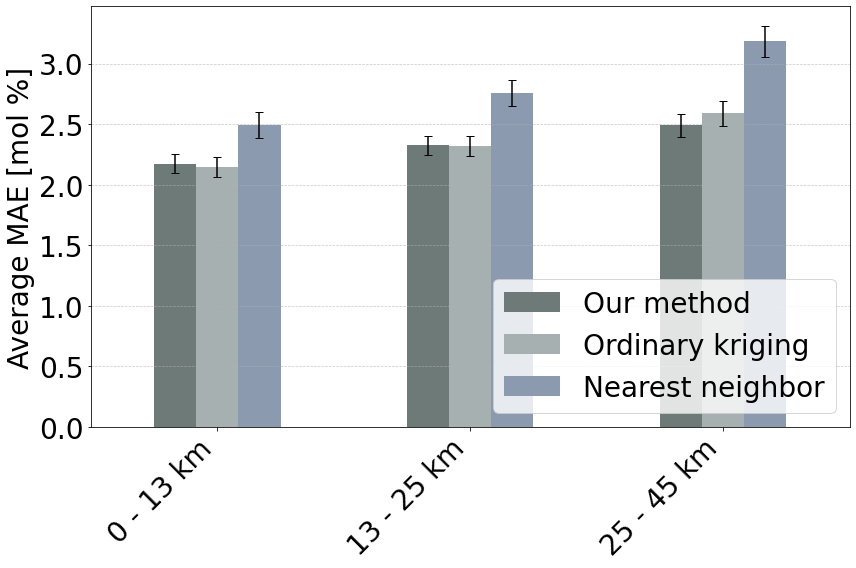

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Our method          819
Ordinary kriging    819
Name: 0 - 2 %, dtype: int64


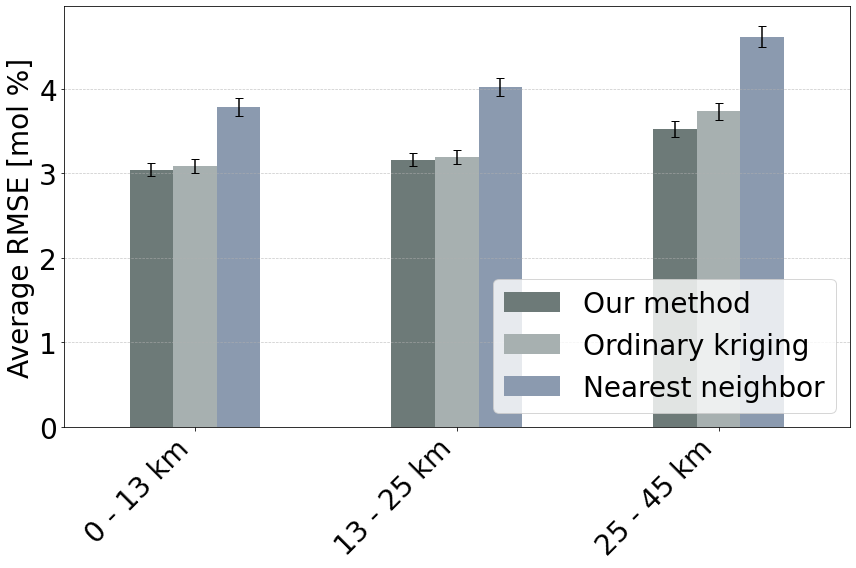

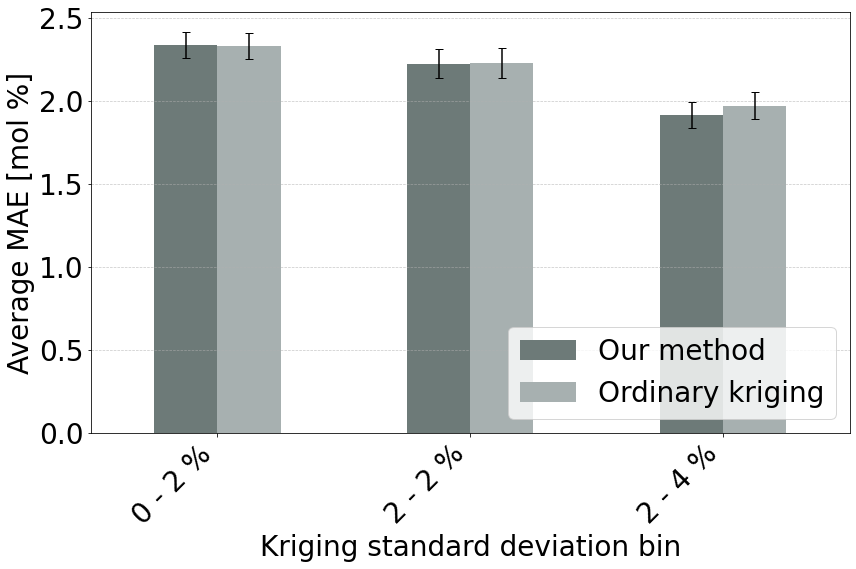

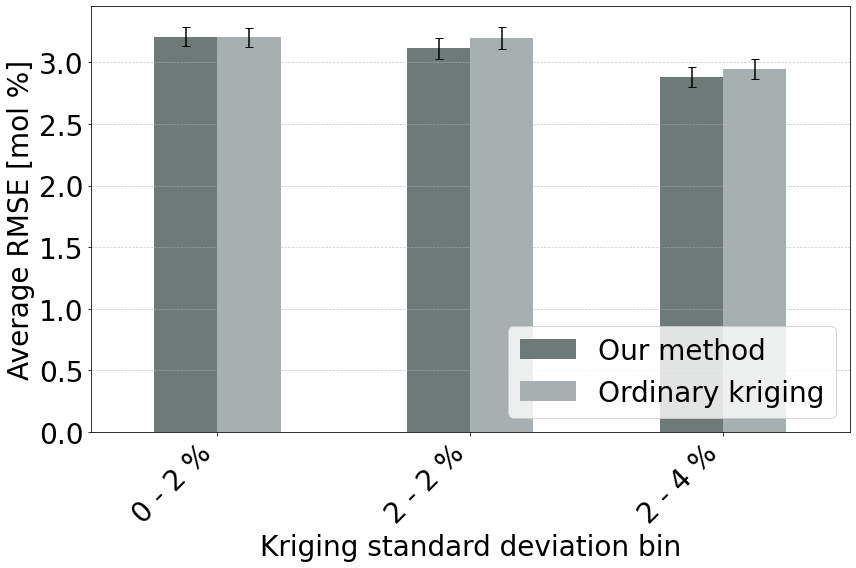

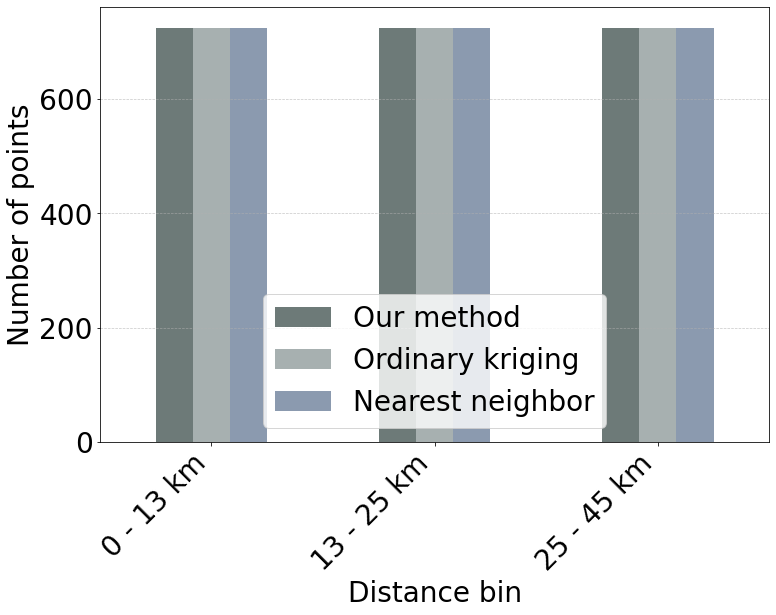

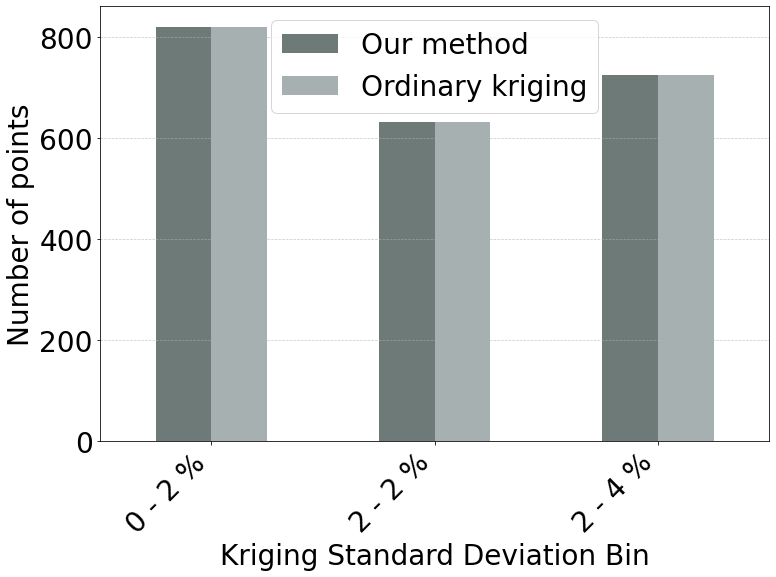

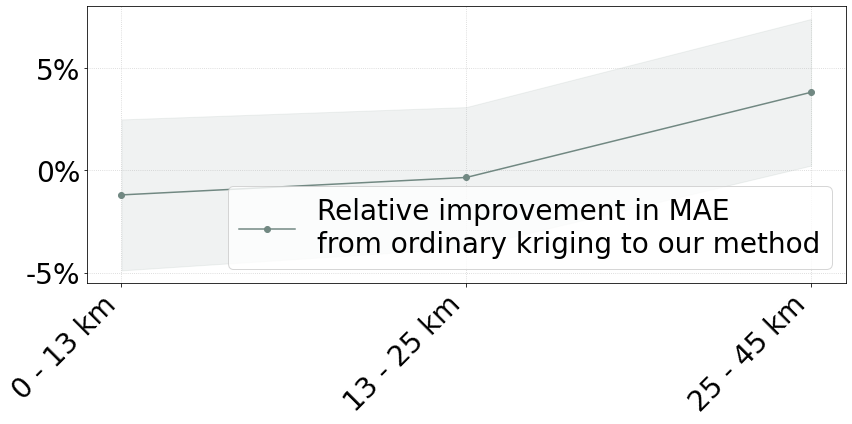

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


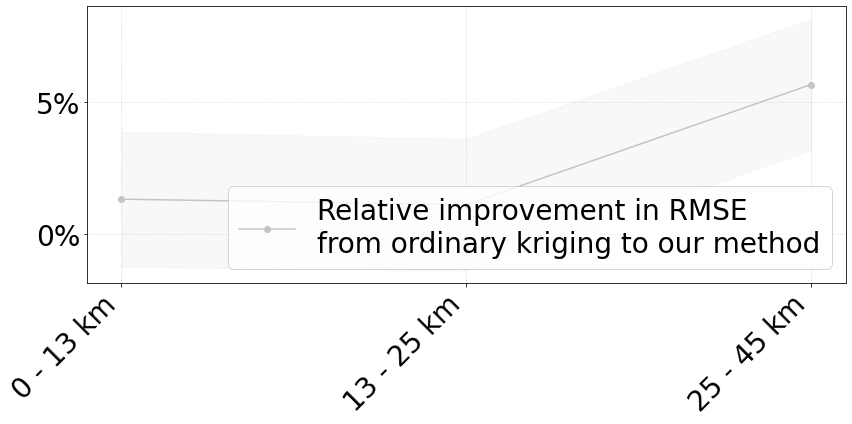

ValueError: Format 'pdepsf' is not supported (supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff, webp)

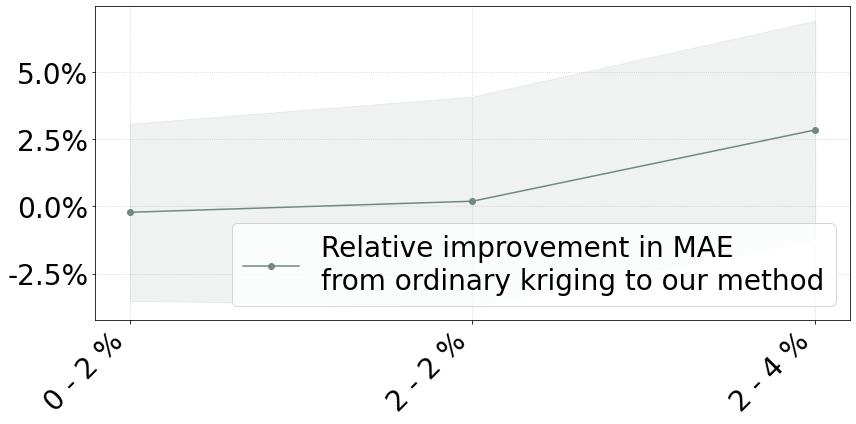

In [9]:
data_source = 'usgs'
list_suffix = f'{data_source}_r0175'
plot_comparison_lists_v4(
            data_source,
            3, 
            0.8, 
            'C2',
            all_data[f'merged_simple_kriging_list_C2_{list_suffix}'],
            all_data[f'merged_kriging_list_C2_{list_suffix}'],
            all_data[f'merged_nn_list_C2_{list_suffix}'],
            propagate=False)

In [ ]:
def run_distance_threshold(comp, list_suffix):
    simple_df_list = all_data[f'merged_simple_kriging_list_{comp}_{list_suffix}']
    kriging_df_list = all_data[f'merged_kriging_list_{comp}_{list_suffix}']
    nn_df_list = all_data[f'merged_nn_list_{comp}_{list_suffix}']

    dataframes_A = simple_df_list
    dataframes_B = kriging_df_list

    # Function to create equal-sized bins and compute mean + standard error
    def bin_and_compute_stats(df_list, bin_column, error_column, n_bins=25, threshold=1):
        concatenated_df = pd.concat(df_list, ignore_index=True)
        sorted_values = concatenated_df[bin_column].dropna().sort_values()

        # Keep only the lower 95% of the data (remove extreme high values)
        upper_cutoff = np.quantile(sorted_values, threshold)
        filtered_values = sorted_values[sorted_values <= upper_cutoff]

        # Define bin edges so that each bin contains an equal number of points
        if len(filtered_values) < n_bins:
            bin_edges = list(filtered_values)
        else:
            bin_edges = [filtered_values.iloc[0]]
            for i in range(1, n_bins):
                cutoff_index = int(len(filtered_values) * i / n_bins)
                bin_edges.append(filtered_values.iloc[cutoff_index])
            bin_edges.append(filtered_values.iloc[-1])

        bin_edges = sorted(set(bin_edges))  # Ensure unique and sorted bins
        concatenated_df["bin"] = pd.cut(concatenated_df[bin_column], bins=bin_edges, include_lowest=True)

        # Compute mean and standard error for absolute errors
        mean_abs_error = concatenated_df.groupby("bin")[error_column].mean()
        se_abs_error = concatenated_df.groupby("bin")[error_column].sem()

        return mean_abs_error, se_abs_error, bin_edges

    # Compute new absolute error for kriging in dataframes_B
    for df in dataframes_B:
        df["abs_error_nn"] = np.abs(df[f"{comp}_x"] - df[f"{comp}_predic_gor"])

    # Compute binned stats for both lists with equal-size bins
    mean_abs_error_A, se_abs_error_A, bin_edges = bin_and_compute_stats(dataframes_B, "closest_distance", "abs_error")
    mean_abs_error_B, se_abs_error_B, _ = bin_and_compute_stats(dataframes_B, "closest_distance", "abs_error_nn")
#     mean_abs_error_C, se_abs_error_C, _ = bin_and_compute_stats(dataframes_B, "closest_distance", "abs_error")

    # Convert bin edges to labels for x-axis
    bin_labels = [f"{int(interval.left / 1000)} - {int(interval.right / 1000)} km" for interval in mean_abs_error_A.index]

    # Compute shaded area limits (mean ± SE)
    lower_A, upper_A = mean_abs_error_A - se_abs_error_A, mean_abs_error_A + se_abs_error_A
    lower_B, upper_B = mean_abs_error_B - se_abs_error_B, mean_abs_error_B + se_abs_error_B
#     lower_C, upper_C = mean_abs_error_C - se_abs_error_C, mean_abs_error_C + se_abs_error_C

    
    # Define the requested colors
    color_histogram = "#6b756f"  # More vibrant blue-grey for "Our method"
    color_shaded_nn = "#533a8b"  # Stronger muted red-orange for NN uncertainty shaded area
    color_mean_nn = "#533a8b"  # Deep, warm red-orange for NN Absolute Error

    plt.show()
    # Define font sizes to match the given formatting
    LARGE_FONT = 22
    MEDIUM_FONT = 18
    SMALL_FONT = 16

    # Re-run the plot with updated font sizes
    plt.figure(figsize=(10, 8))

    # Plot main lines with specified colors
    plt.plot(bin_labels, mean_abs_error_A, label="Ordinary kriging", color=color_histogram, marker="o", linestyle="-")
    plt.plot(bin_labels, mean_abs_error_B, label="Non-linear model", color=color_mean_nn, marker="o", linestyle="-")
#     plt.plot(bin_labels, mean_abs_error_C, label="Our method", color=color_mean_nn, marker="o", linestyle="-")

    # Fill between for shaded standard error regions
    plt.fill_between(bin_labels, lower_A, upper_A, color=color_histogram, alpha=0.2)
    plt.fill_between(bin_labels, lower_B, upper_B, color=color_shaded_nn, alpha=0.2)
#     plt.fill_between(bin_labels, lower_C, upper_C, color=color_shaded_nn, alpha=0.2)

    # Labels and aesthetics with updated font sizes
    plt.xlabel("", fontsize=LARGE_FONT)
    plt.ylabel("Mean Absolute Error", fontsize=LARGE_FONT)
    plt.xticks(fontsize=MEDIUM_FONT)
    plt.yticks(fontsize=MEDIUM_FONT)
    plt.xticks(ticks=range(len(bin_labels)), labels=bin_labels, rotation=45, ha="right", fontsize=LARGE_FONT)

    # Adjust legend font size and align text to the right
    legend = plt.legend(fontsize=MEDIUM_FONT, title_fontsize=MEDIUM_FONT, loc="upper right", frameon=True)
    for text in legend.get_texts():
        text.set_ha("right")

    # Grid settings
    plt.grid(True, linestyle="dotted", alpha=0.6)
    plt.tight_layout()

    # Show plot
    plt.show()


def run_comparison_std(data_source, comp, list_suffix):
    simple_df_list = all_data[f'merged_simple_kriging_list_{comp}_{list_suffix}']
    kriging_df_list = all_data[f'merged_kriging_list_{comp}_{list_suffix}']
    nn_df_list = all_data[f'merged_nn_list_{comp}_{list_suffix}']

    dataframes_A = simple_df_list
    dataframes_B = kriging_df_list

    # Combine all std_C1 values into one array for distribution plot
    std_C1_values = np.concatenate([df[f"std_{comp}"].values for df in kriging_df_list])

    # Compute 95% confidence interval for Kriging (±1.96σ)
    lower_bound_std_C1, upper_bound_std_C1 = np.percentile(std_C1_values, [2.5, 97.5])
    mean_std_C1 = np.mean(std_C1_values)

    # Compute 1/sqrt(beta_C1), taking the mean for each of the 4 (a, b) cases
    beta_C1_values = np.array([np.mean(1 / np.sqrt(df[f"beta_{comp}"].values)) for df in kriging_df_list if df[f"beta_{comp}"].iloc[0] > 0])

    # Compute mean and standard error for Non-linear model
    mean_sigma_nn = np.mean(beta_C1_values)
    sigma_sigma_nn = np.std(beta_C1_values, ddof=1)  # Standard deviation of the 4 values
    se_sigma_nn = sigma_sigma_nn / np.sqrt(4)  # Standard error of the mean (since we have 4 values)

    # Compute 95% confidence interval using SE
    lower_bound_sigma_nn = mean_sigma_nn - 1.96 * se_sigma_nn
    upper_bound_sigma_nn = mean_sigma_nn + 1.96 * se_sigma_nn


    # Define the requested colors
    color_histogram = "#6b756f"  
    color_shaded_nn = "#5f78b9"  
    color_mean_nn = "#5f78b9" 
    
    
    # Define large font sizes
    LARGE_FONT = 22
    MEDIUM_FONT = 18
    SMALL_FONT = 16

    # Create the plot
    plt.figure(figsize=(10, 8))
    sns.histplot(std_C1_values, bins=30, kde=True, color=color_histogram, alpha=0.2, edgecolor="black", stat="density")

    # Add shaded area for the Non-linear model uncertainty range (95% CI from SE)
    plt.axvspan(lower_bound_sigma_nn, upper_bound_sigma_nn, color=color_shaded_nn, alpha=0.1)

    # Draw vertical lines for means
    plt.axvline(mean_sigma_nn, color=color_mean_nn, linestyle="solid", linewidth=4, label=f"Non-linear model uncertainty:\n{mean_sigma_nn:.1f} [{lower_bound_sigma_nn:.1f}, {upper_bound_sigma_nn:.1f}]")
#     plt.axvline(mean_std_C1, color=color_mean_std, linestyle="solid", linewidth=4)

    # Labels and aesthetics
    
    plt.xlabel("Standard deviation from kriging [mol %]", fontsize=LARGE_FONT)
    plt.ylabel("Density", fontsize=LARGE_FONT)
    plt.xticks(fontsize=LARGE_FONT)
    plt.yticks(fontsize=LARGE_FONT)

    # Create a single legend with both Non-linear Model and Kriging means + confidence intervals
    legend_patch = [
        mpatches.Patch(color=color_mean_nn, )]
    
    print(f"Kriging: {mean_std_C1:.1f} [{lower_bound_std_C1:.1f}, {upper_bound_std_C1:.1f}]")
    legend = plt.legend(fontsize=LARGE_FONT, 
               title_fontsize=LARGE_FONT, loc="upper right")
    for text in legend.get_texts():
        text.set_ha("right")  # Align text to the right
    # Grid and show plot
    plt.grid(True, linestyle="dotted", alpha=0.6)
    plt.tight_layout()
    plt.savefig(f"{data_source}_{comp}_std_comparison.png")
    plt.show()

comp = 'C1'
data_source = 'usgs'
list_suffix = f'{data_source}_r0175'

run_comparison_std(data_source, comp, list_suffix)

comp = 'C2'
data_source = 'usgs'
list_suffix = f'{data_source}_r0175'
run_comparison_std(data_source, comp, list_suffix)

comp = 'C1'
data_source = 'ghgrp'
list_suffix = f'{data_source}_r015'
run_comparison_std(data_source, comp, list_suffix)

In [93]:
def plot_estimation_vs_observation(comp, merged_kriging_list, merged_nn_list):
    # Combine all dataframes for each method
    df_kriging = pd.concat(merged_kriging_list, ignore_index=True)
    df_nn = pd.concat(merged_nn_list, ignore_index=True)
    
    # Set up the figure
    fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
    
    # Define plot settings
    settings = [
        ("Our method", df_kriging, "orange"),
        ("Nearest Neighbor", df_nn, "gray")
    ]
    
    for ax, (title, df, color) in zip(axes, settings):
        sns.scatterplot(
            ax=ax,
            x=f"{comp}_x",
            y=f"{comp}_y",
            data=df,
            color=color,
            alpha=0.7,
            s=20
        )
        # Add error bars
        ax.errorbar(
            df[f"{comp}_x"],
            df[f"{comp}_y"],
            yerr=df[f"std_{comp}"],
            fmt='o',
            color=color,
            alpha=0.5,
            markersize=5
        )
        
        # Add dashed 1:1 reference line
        ax.plot([df[f"{comp}_x"].min(), df[f"{comp}_x"].max()],
                [df[f"{comp}_x"].min(), df[f"{comp}_x"].max()],
                linestyle="--", color="black", alpha=0.7)
        
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(f"Observed {comp} fraction (%)", fontsize=12)
        ax.set_ylabel(f"Estimated {comp} fraction (%)", fontsize=12)
    
    plt.tight_layout()
    plt.show()

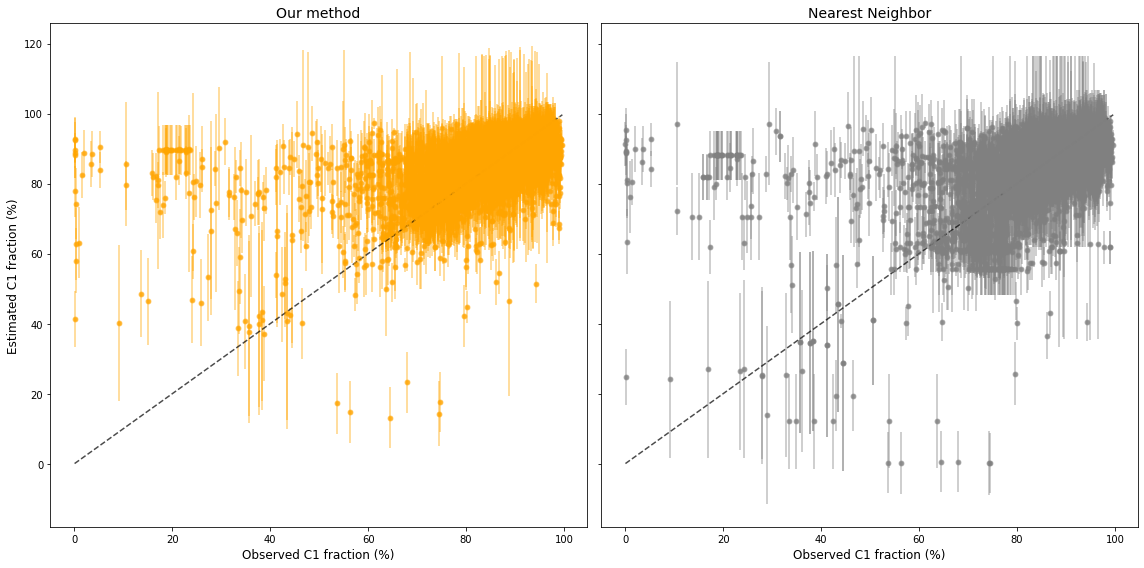

In [89]:
comp = 'C1'
plot_estimation_vs_observation(comp, merged_kriging_list_C1, merged_simple_kriging_list_C1)

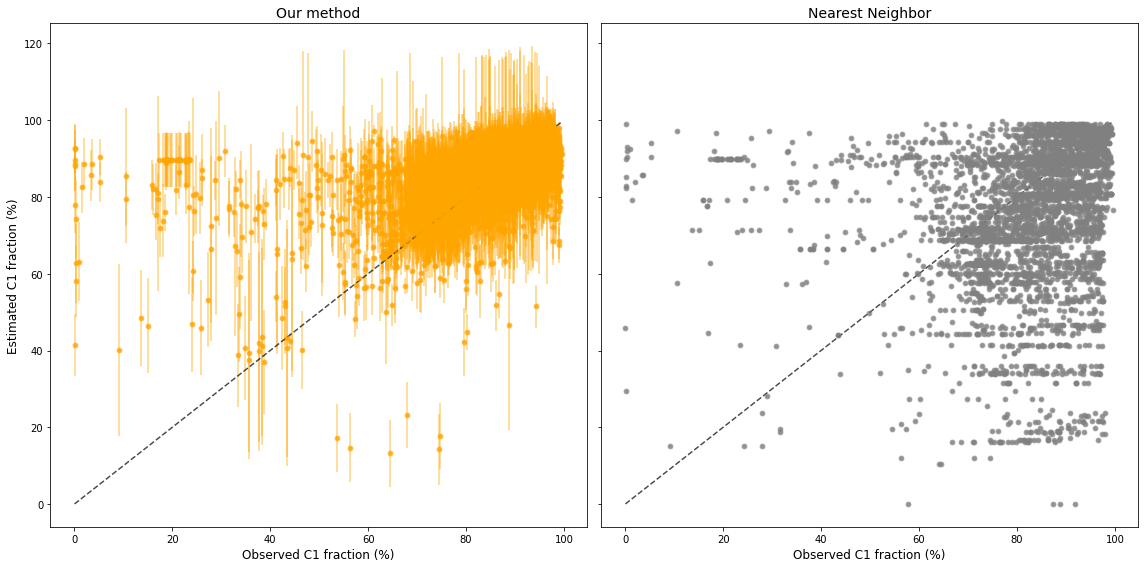

In [66]:
comp = 'C1'
plot_estimation_vs_observation(comp, merged_kriging_list_C1, merged_nn_list_C1)

In [21]:
from scipy.stats import gaussian_kde

def plot_estimation_vs_observation_with_densities(comp, merged_kriging_list, merged_nn_list, merged_simple_kriging_list):
    df_kriging = pd.concat(merged_kriging_list, ignore_index=True)

    df_kriging = df_kriging[~pd.isna(df_kriging[f"{comp}_x"])]
    df_nn = pd.concat(merged_nn_list, ignore_index=True)
    df_nn = df_nn[~pd.isna(df_nn[f"{comp}_x"])]

    df_simple_kriging = pd.concat(merged_simple_kriging_list, ignore_index=True)
    df_simple_kriging = df_simple_kriging[~pd.isna(df_simple_kriging[f"{comp}_x"])]

#     df_kriging = df_kriging[df_kriging.closest_distance > 50000]
#     df_nn = df_nn[df_nn.closest_distance > 50000]
#     df_simple_kriging = df_simple_kriging[df_simple_kriging.closest_distance > 50000]

    settings = [
        ("Our method", df_kriging, "#c8bc95"),
        ("Nearest Neighbor", df_nn, '#caa372'),
        ("Simple Kriging", df_simple_kriging, '#aca190'),
    ]
    
    for label, df, color in settings:
        observed = df[f"{comp}_x"].to_numpy()
        estimated = df[f"{comp}_y"].to_numpy()
        std_dev = df[f"std_{comp}"].to_numpy()
        
        # Compute MAE and R²
        mae = np.mean(np.abs(observed - estimated))
        
        r_squared = 1 - (np.sum((observed - estimated) ** 2) / np.sum((observed - np.mean(observed)) ** 2))

        # Compute density with Gaussian KDE
        xy = np.vstack([observed, estimated])
        z = gaussian_kde(xy)(xy)

        # Sort points by density
        idx = z.argsort()
        observed, estimated, std_dev = observed[idx], estimated[idx], std_dev[idx]

        # Set up the axes with gridspec
        fig = plt.figure(figsize=(12, 12))
        grid = plt.GridSpec(4, 4, hspace=0.01, wspace=0.01)
        main_ax = fig.add_subplot(grid[1:, :-1])
        y_hist = fig.add_subplot(grid[1:, -1], sharey=main_ax)
        x_hist = fig.add_subplot(grid[0, :-1], sharex=main_ax)

        # Scatter plot without density coloring
        main_ax.scatter(observed, estimated, color=color, edgecolor=color, alpha=0.3)

        # Custom error bars
        for x, y, e in zip(observed, estimated, std_dev):
            main_ax.plot([x, x], [y - e, y + e], color=color, lw=1)  # Vertical error bar

        # 1:1 reference line
        main_ax.plot([observed.min(), observed.max()], [observed.min(), observed.max()], 'k--', alpha=0.7, lw=2)
        
        # Contour plot for the marginals
        x = np.linspace(observed.min(), observed.max(), 1000)
        y = np.linspace(estimated.min(), estimated.max(), 1000)
        kde_x = gaussian_kde(observed, bw_method=0.2)
        kde_y = gaussian_kde(estimated, bw_method=0.2)
        

        
        # Set the labels for the axes
        main_ax.set_xlabel(f'Observed {comp} fraction (%)', fontsize=24)
        main_ax.set_ylabel(f'Estimated {comp} fraction (%)', fontsize=24)
        
        # Keep only main scatter plot ticks
        main_ax.set_xticks(np.arange(0,100,10))
        main_ax.set_yticks(np.arange(0,100,10))

        main_ax.tick_params(axis='both', which='both', labelsize=24)
        
        alpha_hist = 0.6
        colorhist = 'lightblue'
        x_hist.plot(x, kde_x(x), alpha=alpha_hist, color=color)
        x_hist.fill_between(x, 0, kde_x(x), alpha=alpha_hist, color=color)
        x_hist.set_xlim(observed.min(), observed.max())
#         x_hist.set_xticks([])
#         x_hist.set_yticks([])
#         x_hist.spines["left"].set_visible(False)
        x_hist.spines["bottom"].set_visible(False)

        y_hist.plot(kde_y(y), y, alpha=alpha_hist, color=color)
        y_hist.fill_betweenx(y, 0, kde_y(y), alpha=alpha_hist, color=color)
        y_hist.set_ylim(estimated.min(), estimated.max())
#         y_hist.set_xticks([])
#         y_hist.set_yticks([])
#         y_hist.spines["top"].set_visible(False)
#         y_hist.spines["right"].set_visible(False)
        
        # Hide spines on histograms
        for spine in x_hist.spines.values():
            spine.set_visible(False)
        for spine in y_hist.spines.values():
            spine.set_visible(False)
        
        # Add MAE and R² annotation
        
        main_ax.text(0.05, 0.2, f'MAE: {mae:.3f}', transform=main_ax.transAxes, fontsize=24,
                     verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
        
        main_ax.grid(True, alpha=0.8)
        plt.show()


In [101]:
(2.320 - 2.305)*100/2.320

0.6465517241379173

In [11]:
(2.888 - 2.305)*100/2.305

25.29284164859001

In [12]:
(2.888 - 2.305)*100/2.888

20.186980609418274

In [13]:
(9.427 - 5.759)*100/9.427 

38.909515222234006

In [14]:
(6.764 - 5.759)*100/6.764

14.85807214665878

In [ ]:
(2.320 - 2.305)*100/2.305

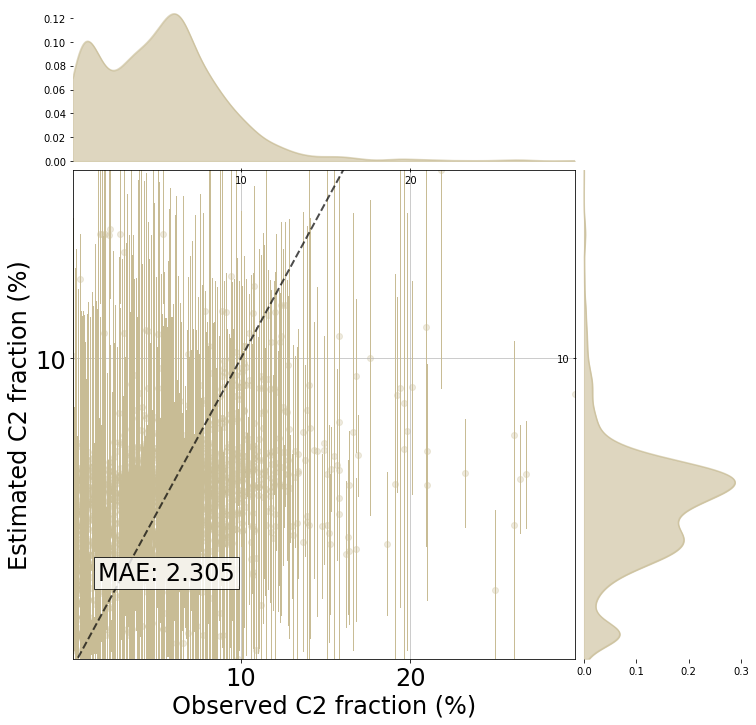

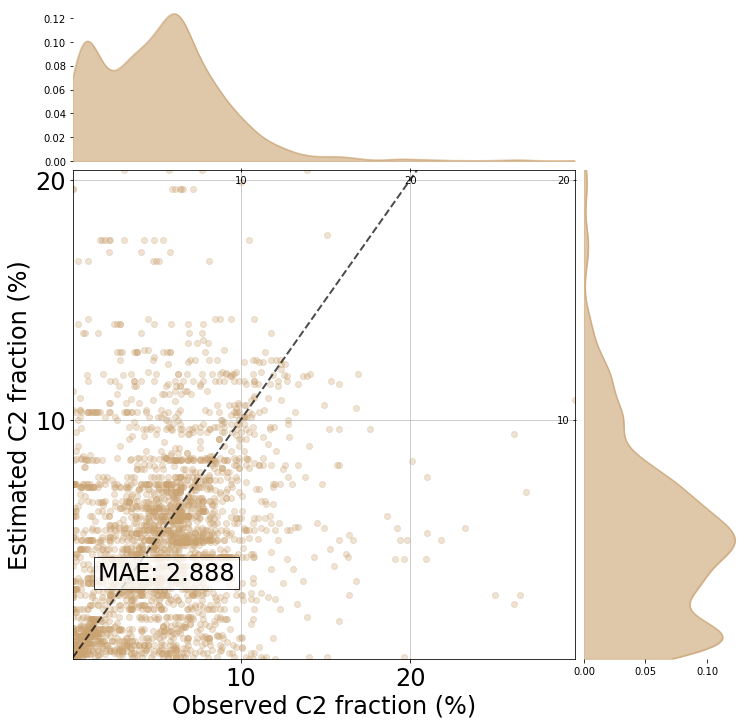

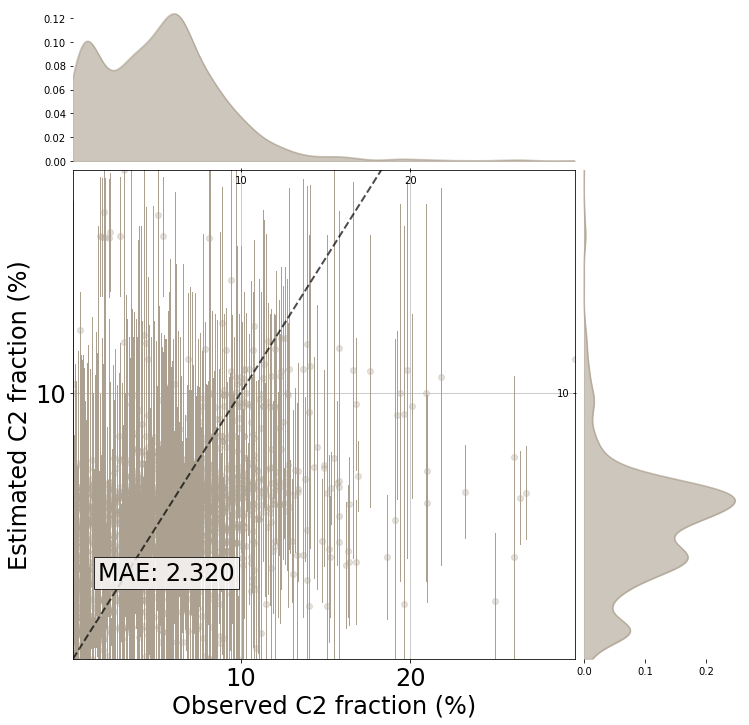

In [22]:
comp = 'C2'
list_suffix = f'{comp}_usgs_r0175'

plot_estimation_vs_observation_with_densities(comp,
            all_data[f'merged_kriging_list_{list_suffix}'],
            all_data[f'merged_nn_list_{list_suffix}'],
            all_data[f'merged_simple_kriging_list_{list_suffix}'])

In [17]:
(6.764 - 5.759)/6.764

0.1485807214665878

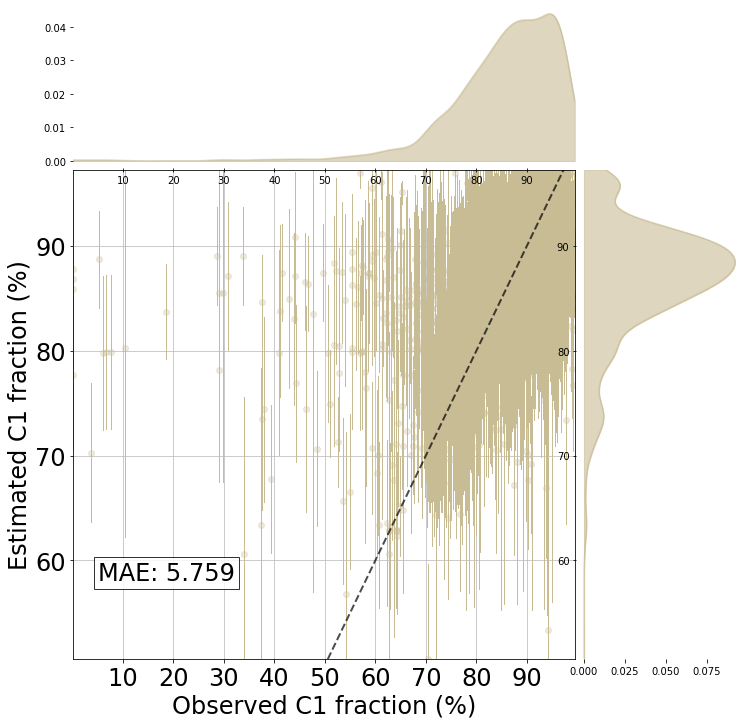

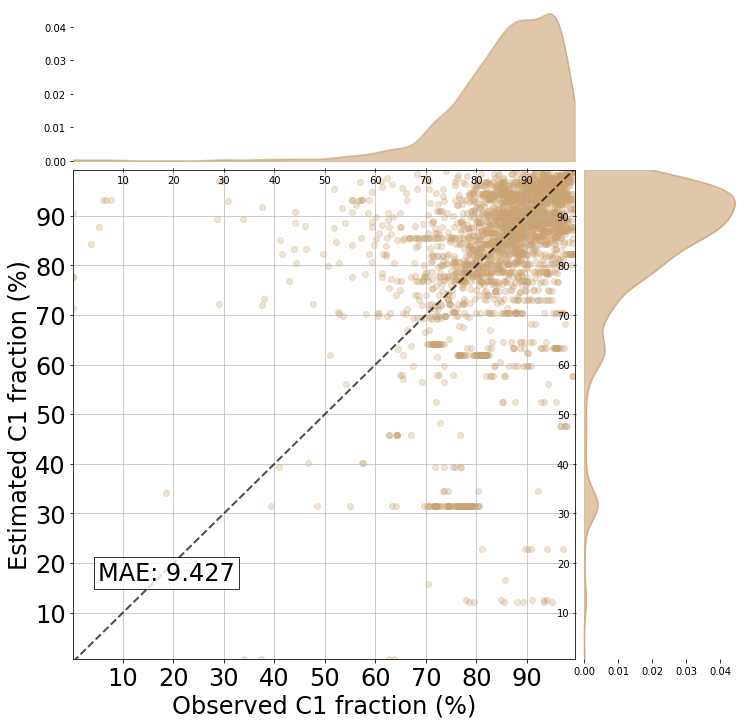

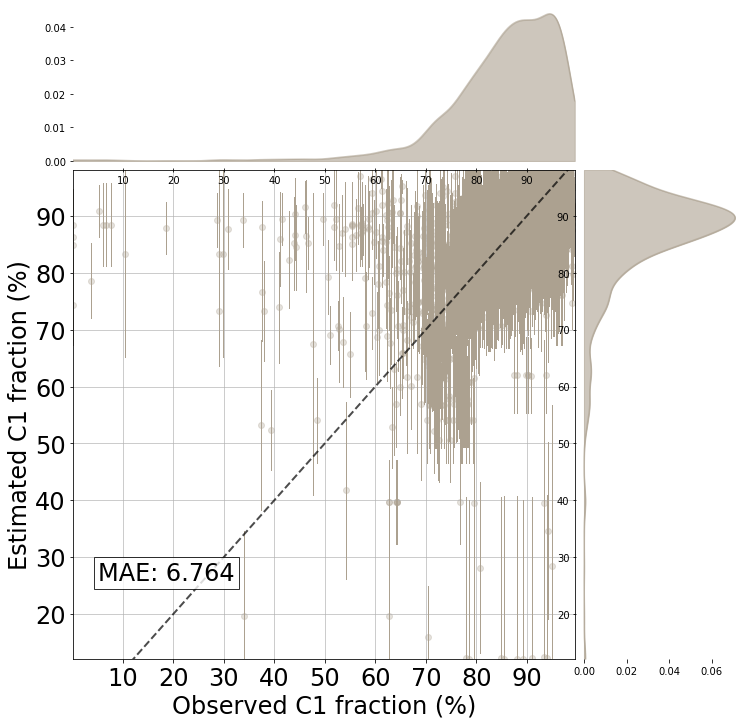

In [23]:
comp = 'C1'
list_suffix = f'{comp}_usgs_r0175'

plot_estimation_vs_observation_with_densities(comp,
            all_data[f'merged_kriging_list_{list_suffix}'],
            all_data[f'merged_nn_list_{list_suffix}'],
            all_data[f'merged_simple_kriging_list_{list_suffix}'])

In [ ]:
comp = 'C1'
list_suffix = f'{comp}_ghgrp_r0175'

plot_estimation_vs_observation_with_densities(comp,
            all_data[f'merged_kriging_list_{list_suffix}'],
            all_data[f'merged_nn_list_{list_suffix}'],
            all_data[f'merged_simple_kriging_list_{list_suffix}'])

In [7]:
comp = 'C1'
list_suffix = f'{comp}_ghgrp_r0175'
pd.concat(all_data[f'merged_kriging_list_{list_suffix}']).abs_error.mean()

4.9997614848289595

In [8]:
comp = 'C1'
list_suffix = f'{comp}_ghgrp_r0175'
pd.concat(all_data[f'merged_simple_kriging_list_{list_suffix}']).abs_error.mean()

5.057851747556639

In [9]:
comp = 'C1'
list_suffix = f'{comp}_ghgrp_r0175'
pd.concat(all_data[f'merged_nn_list_{list_suffix}']).abs_error.mean()

5.5697351430091535

In [15]:
(5.057851747556639 - 4.9997614848289595) * 100/5.057851747556639

1.1485165170319986

In [16]:
(5.569735143009153 - 5.057851747556639) * 100/5.569735143009153

9.190444111063403

In [ ]:
comp = 'C1'
list_suffix = f'{comp}_ghgrp_r0175'
pd.concat(all_data[f'merged_nn_list_{list_suffix}']).abs_error.mean()

In [ ]:
for i in range(3):
    plot_estimation_vs_observation_with_densities(comp,
                                              [merged_kriging_list_C1[i]],
                                              [merged_nn_list_C1[i]],
                                              [merged_simple_kriging_list_C1[i]])